<h1 style="font-family:Impact,Arial;font-size:50px">Sanity check MWATS export from VAST</h1>
<p> The raw flux measurements are extracted form the VAST pipeline - this script checks that measurements presented in previous papers are reproduced in the latest analysis. 

The light-curves generated for the Bell et al. 2016, 2018 were created using a different algorithm with different filtering, however the main disribution of points should approximately be the same. 

In [1]:
import math
import pandas as pd
import numpy as np

In [2]:
def distance_from_median_pos(df):
    degrees_to_radians = np.pi/180.0
    phi1 = df.ra*degrees_to_radians
    phi2 = df.med_ra*degrees_to_radians

    theta1 = df.dec*degrees_to_radians
    theta2 = df.med_dec*degrees_to_radians
    
    cosine = (np.cos(phi1)*np.cos(phi2)*np.cos(theta1 - theta2) +
           np.sin(phi1)*np.sin(phi2))
    dist_from_centre = np.arccos(cosine)
    return (dist_from_centre/3.142)*180

## Load the data

In [3]:
%%time
# Load the raw data file.
raw_data = pd.read_feather('mwats_raw_data_Feb_SQL.fth')
raw_data = raw_data.sort('jd')

/Users/134393/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 3.27 s, sys: 7.81 s, total: 11.1 s
Wall time: 26.2 s


# GLEAM J041022-523247

In [4]:
import json
import matplotlib.pyplot as plt
source = 29267.0
source_data = raw_data[raw_data.source_id == source]
file = '../sanity_check/GLEAM_J041022-523247.txt'
source = json.load(open(file))
fluxes = source['peak_flux']
errors = source['s_error']
s_time = source['jd_time']

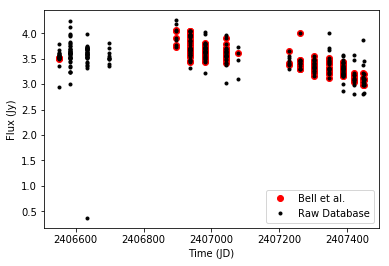

In [5]:
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

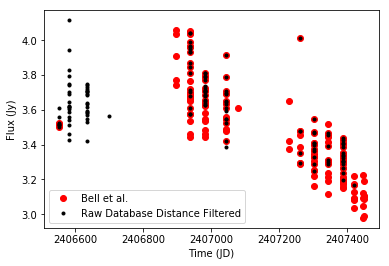

In [6]:
# Plot with distance filtering
source_filt = source_data[source_data.distance < 15.0]
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_filt.jd-50000, source_filt.raw_peak_flux, 'k.', label='Raw Database Distance Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

In [7]:
source_data['med_ra']      = np.median(source_data.ra)
source_data['med_dec']     = np.median(source_data.dec)
source_data['mean_flux']   = np.mean(source_data.raw_peak_flux)
source_data['flux_offset'] = distance_from_median_pos(source_data)
fil_source1 = source_filt[source_filt.flux_offset < (2.0/60)] # Approximately 1 arc minute in Bell et al. 2018
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
#plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.plot(fil_source1.jd-50000, fil_source1.raw_peak_flux, 'k.', label='Raw Database Image and Offset Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

AttributeError: 'DataFrame' object has no attribute 'flux_offset'

# J0953+0755

In [ ]:
interesting = raw_data[ (raw_data.ra > 148.0) & (raw_data.ra < 148.5) & (raw_data.dec < 8.0) & (raw_data.dec > 7.0)]

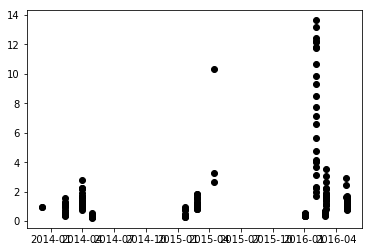

In [8]:
J0953 = raw_data[raw_data.source_id==243604.0]
plt.plot(J0953.time, J0953.raw_peak_flux, 'ko')

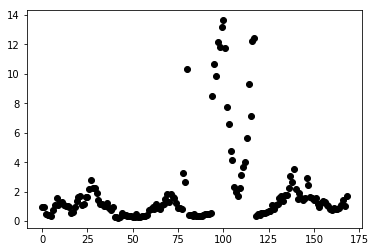

In [10]:
plt.plot(list(J0953.raw_peak_flux), 'ko')

# GLEAM J032320+053413

In [45]:
interesting = raw_data[ (raw_data.ra > 50.0) & (raw_data.ra < 51.0) & (raw_data.dec < 6.0) & (raw_data.dec > 5.0)]

In [48]:
source = 237262.0
source_data = raw_data[raw_data.source_id == source]
file = '../sanity_check/GLEAM_J032320+053413.txt'
source = json.load(open(file))
fluxes = source['peak_flux']
errors = source['s_error']
s_time = source['jd_time']

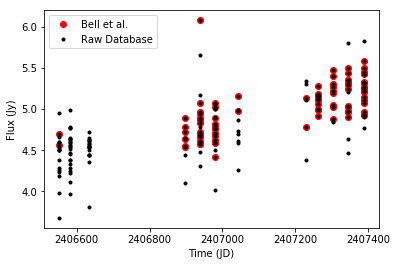

In [49]:
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

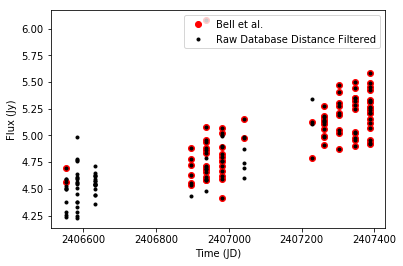

In [50]:
# Plot with distance filtering
source_filt = source_data[source_data.distance < 15.0]
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_filt.jd-50000, source_filt.raw_peak_flux, 'k.', label='Raw Database Distance Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

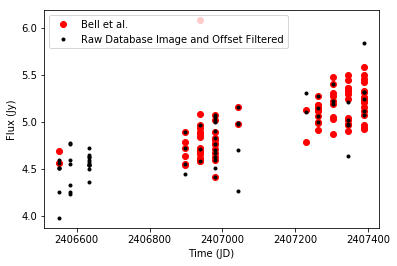

In [57]:
source_data['med_ra']      = np.median(source_data.ra)
source_data['med_dec']     = np.median(source_data.dec)
source_data['mean_flux']   = np.mean(source_data.raw_peak_flux)
source_data['flux_offset'] = distance_from_median_pos(source_data)
fil_source1 = source_data[source_data.flux_offset < (0.0/60)] # Approximately 1 arc minute in Bell et al. 2018
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
#plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.plot(fil_source1.jd-50000, fil_source1.raw_peak_flux, 'k.', label='Raw Database Image and Offset Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()